In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import sys; sys.path.append('../src')
from ml_pipeline import load_surv_data
import yaml

/gpfs3/well/clifton/users/wra194/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load features & outcomes

In [2]:
# Load features & outcomes

X_train, X_test, y_train, y_test = load_surv_data(
    features_path="data/processed/showcase_processed.feather",
    outcomes_path="data/processed/surv_outcomes_crc.feather",
    split_ratio=0.8,
    random_state=42
)


Successfully loaded 499864 samples with matching features and outcomes


In [3]:
# Cox negative log likelihood loss function can only be fed one y column, so have to encode censored individuals as negative T.
# See https://github.com/xiaonanl1996/MLforBrCa/blob/main/Scripts/Stats_Analysis/JupyterNotebook/XGBoost-Cox.ipynb (Thanks!)
y_train.loc[y_train['E'] == 0, 'T'] = -y_train['T']
y_test.loc[y_test['E'] == 0, 'T'] = -y_test['T']

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train['T'], enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test['T'], enable_categorical=True)

In [5]:
print("Training features shape: ", X_train.shape)
print(f"DMatrix shape: ({dtrain.num_row()}, {dtrain.num_col()})")

Training features shape:  (399891, 1597)
DMatrix shape: (399891, 1597)


## Run XGBoost
Run XGBoost with hyperparameters tuned using stepwise grid-search (*src/hyperparameter_tuning.py*)

In [6]:
with open('../output/hyperparameters/stepwise_showcase.yml', 'r') as f:
    tuned_params = yaml.safe_load(f)

print(tuned_params)

base_params = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda',
}

params = base_params | tuned_params

{'colsample_bytree': 0.7, 'eta': 0.003, 'gamma': 0.0, 'lambda': 16.0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7}


In [7]:
# Output file showed that number of trees for eta of 0.003 = 5447
model = xgb.train(params, dtrain, num_boost_round=5447, early_stopping_rounds=None)

## Assess overfitting
Compute Harrell's C index for train and test sets

In [8]:
# Compute estimated risk scores
risk_scores_train = model.predict(dtrain)
risk_scores_test = model.predict(dtest)

In [9]:
# Make censored times positive again (had to make negative for input to XGBoost)
y_train.loc[y_train['E'] == 0, 'T'] = -y_train['T']
y_test.loc[y_test['E'] == 0, 'T'] = -y_test['T']

In [10]:
# In Cox, higher risk score (linear predictor) = higher hazard = shorter survival. In lifelines library, larger predictor value = longer survival. 
# So make cox risk scores negative to fit this. Acceptable as there is a direct inverse relationship between risk score and survival (so preserved ranking).
c_index_train = concordance_index(event_times=y_train['T'], predicted_scores=-risk_scores_train, event_observed=y_train['E'])
print("Train C-index:", c_index_train)

c_index_test = concordance_index(event_times=y_test['T'], predicted_scores=-risk_scores_test, event_observed=y_test['E'])
print("Test C-index:", c_index_test)

Train C-index: 0.7634548298881324
Test C-index: 0.7044901557938964


## SHAP values

In [11]:
# Set pretty names for features. Format: Feature title (UKB feature ID)
fields_metadata = pd.read_csv('../data/raw/ukb_metadata/field.txt', sep='\t')
pretty_names = []
for col in X_train:
    field_id = int(col.split('.')[0])
    field_title = fields_metadata.loc[fields_metadata['field_id'] == field_id, 'title'].tolist()[0]
    # If one-hot-encoded multi-choice, set field title + choice
    if '_' in col:
        pretty_names.append(field_title + f" ({field_id}): {col.split('_')[1]}")
    # Otherwise just set to field title
    else:
        pretty_names.append(field_title + f" ({field_id})")

In [21]:
# Compute SHAP values. For some reason, throws additivity error/warning when using GPU, so set check_additivity=False for now.
explainer = shap.Explainer(model, feature_names=pretty_names)
shap_values = explainer(dtrain, check_additivity=False)

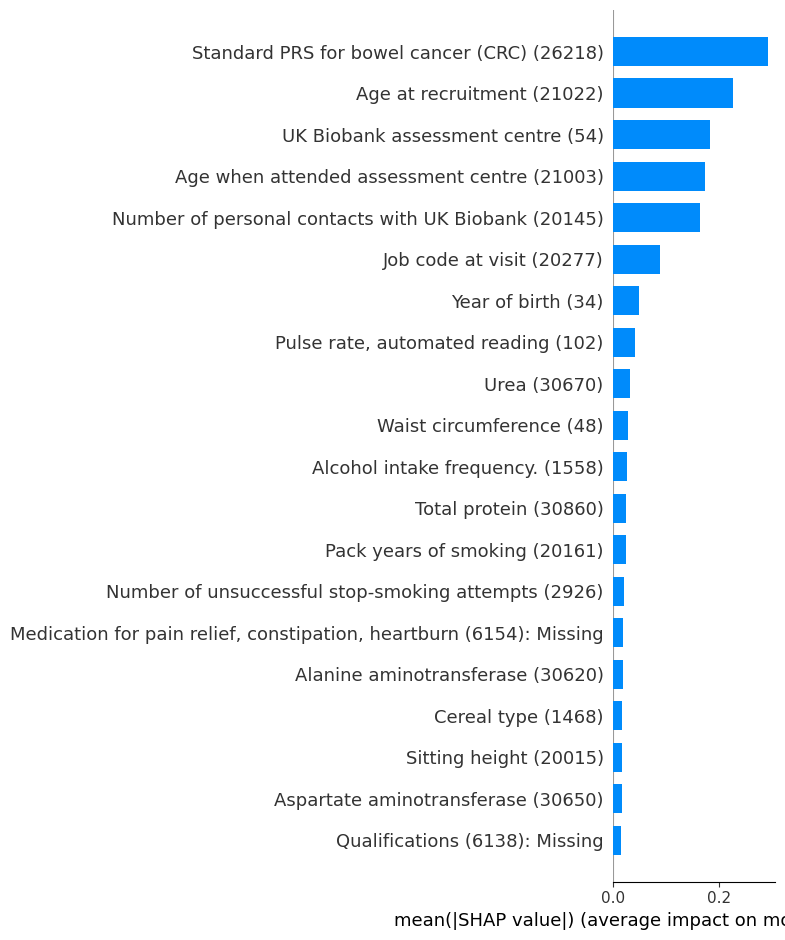

In [22]:
shap.summary_plot(shap_values, plot_type="bar", max_display=20)

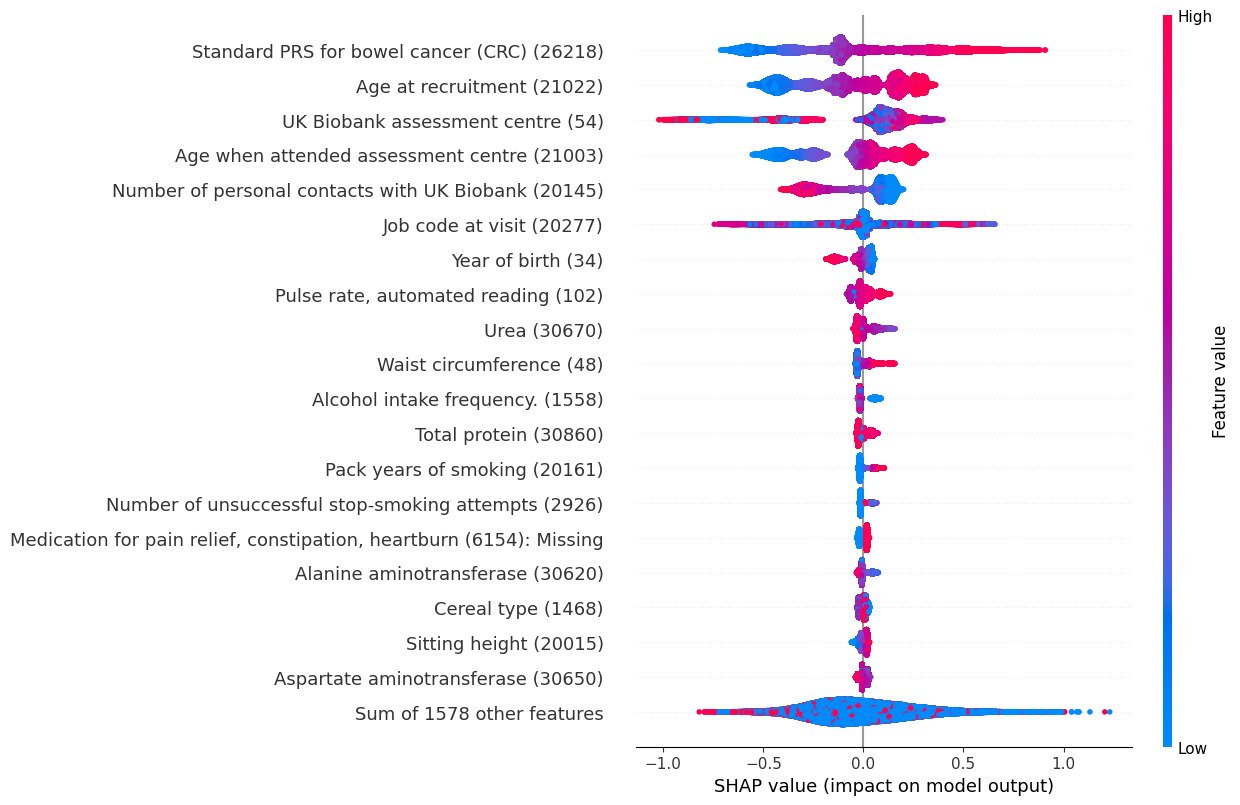

In [23]:
shap.plots.beeswarm(shap_values, max_display=20)